<a href="https://colab.research.google.com/github/nnguyenu/ML-basic/blob/main/Softmax_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np 
import matplotlib.pyplot as plt
import math

(3, 2000)


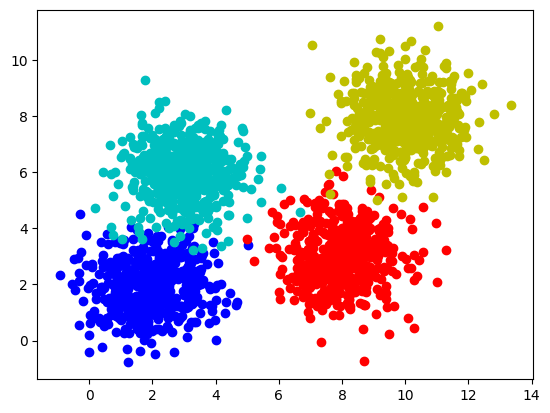

In [23]:
No = 500 # number of data point per class 
d = 2 # data dimension 
C = 4 # number of classes 
N = No*4
means = [[2, 2], [8, 3], [3, 6], [10,8]]
cov = [[1, 0], [0, 1]]

point_format = ['bo','ro','co','yo']

XX = np.empty((C,No,d))
for i in range(C):
  XX[i] = np.random.multivariate_normal(means[i], cov, No)
  plt.plot(XX[i,:,0],XX[i,:,1],point_format[i])

# each column is a datapoint
X = np.concatenate(XX[:], axis = 0).T
X = np.concatenate((np.ones((1, C*No)), X), axis = 0)
# X.shape = (d+1,No*C)
print(X.shape)

original_label = np.asarray([0]*No + [1]*No + [2]*No + [3]*No).T

In [24]:
# i-th col is the w of class i 
W_init = np.random.randn(d+1, C)

In [25]:
""" Compute softmax values for each sets of scores in Z.
    each column of Z is a set of score.    """
def softmax(Z):
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 0)
    return A

def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

In [26]:
## One-hot coding
from scipy import sparse 
def convert_labels(y, C):
    """ convert 1d label to a matrix label: i-th column of this matrix coresponding to i-th element in y. 
    Y[j][i] = 0 if y[i] != j && Y[j][i] = 1 if y[i] = j
    ex: y = [0, 2, 1, 0], and 3 classes:
            [[1, 0, 0, 1],
             [0, 0, 1, 0],
             [0, 1, 0, 0]]  """
    N = len(y)
    # Return an array of ones with same shape & type as given array
    data = np.ones_like(y)
    Y = sparse.coo_matrix( (data,(y, np.arange(N))), shape = (C, N)).toarray()
    """
      Example of coo_matrix: Constructing a matrix using ijv format
      row  = np.array([0, 3, 1, 0])
      col  = np.array([0, 3, 1, 2])
      data = np.array([4, 5, 7, 9])
      coo_matrix((data, (row, col)), shape=(4, 4)).toarray() 
      >>> array([[4, 0, 9, 0],
       [0, 7, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 5]]) """
    return Y 

In [27]:
def softmax_regression(X, y, W_init, eta, tol = 1e-4, max_count = 10000):
    W = [W_init]    
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    it = 0
    N = X.shape[1]
    d = X.shape[0]
  
    check_w_after = 20
    for count in range(max_count):
        # mix data 
        mix_id = np.random.permutation(N)
        for i in mix_id:
            # take data point i at i-th col data X & col label Y
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            # calculate softmax of xi with all class
            zi = np.dot(W[-1].T, xi)
            ai = softmax(zi)
            W_new = W[-1] + eta*xi.dot((yi - ai).T)
            count += 1
            # stopping criteria
            if count > check_w_after:                
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

In [28]:
W = softmax_regression(X, original_label, W_init, eta = 0.1)

In [29]:
def pred(W, X):
    """
    predict output of each columns of X
    Class of each x_i is determined by location of max probability
    Note that class are indexed by [0, 1, 2, ...., C-1]
    """
    A = softmax_stable(np.dot(W.T,X))
    return np.argmax(A, axis = 0)

[[ 23.37584897   4.07778746  -0.15686516 -26.59218336]
 [ -2.11842675   2.67140392  -2.45078162   1.36988692]
 [ -2.96007945  -3.48308904   3.20714009   3.79158968]]
Prediction rate: 97.65 %


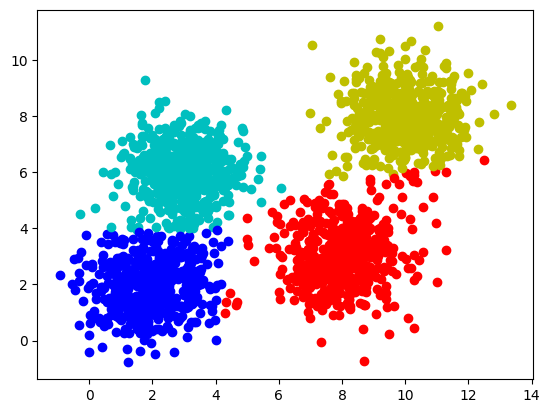

In [30]:
print(W[-1])
prediction = pred(W[-1],X)

correct = 0
for i in range(N):
  if prediction[i] == original_label[i]:
    correct += 1
print('Prediction rate:',correct/N*100,'%')

for i in range(N):
  plt.plot(X[1,i],X[2,i],point_format[prediction[i]])

In [31]:
# cost or loss function
# we can use numerical_grad to check if the grad formula is correct  
def cost(X, Y, W):
    A = softmax(W.T.dot(X))
    return -np.sum(Y*np.log(A))

def grad(X, Y, W):
    A = softmax((W.T.dot(X)))
    E = A - Y
    return X.dot(E.T)
    
def numerical_grad(X, Y, W, cost):
    eps = 1e-6
    g = np.zeros_like(W)
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_p = W.copy()
            W_n = W.copy()
            W_p[i, j] += eps 
            W_n[i, j] -= eps
            g[i,j] = (cost(X, Y, W_p) - cost(X, Y, W_n))/(2*eps)
    return g 